<a href="https://colab.research.google.com/github/srivatsalnarayan/Gan_cifar/blob/main/keras_cifar10_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

simple


In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

170498071/170498071 [==============================] - 3s 0us/step


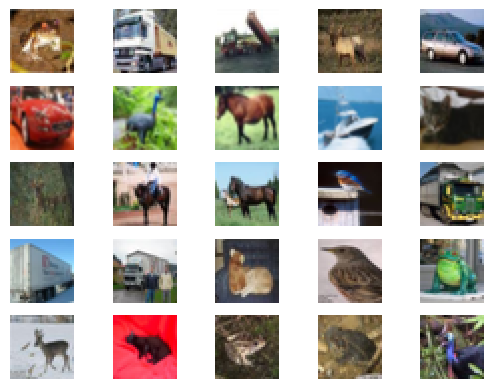

In [ ]:

#Load data and plot to get a quick understanding
#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()


In [ ]:
#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

In [ ]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.


In [ ]:

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector.
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.

test_gen = define_generator(100)
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant.
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:
# load cifar training images
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale
                            #original images to -1 to 1 to match the output of generator.
	return X


In [ ]:
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y


In [ ]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


In [ ]:
# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y


In [ ]:

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.


In [ ]:

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
  #the discriminator model is updated for a half batch of real samples
  #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs and bacthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_2epochs.h5')


In [ ]:

###################################################################
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

################################################################################


2/2 [==============================] - 1s 367ms/step
Epoch>1, Batch 1/390, d1=0.704, d2=0.697 g=0.689
2/2 [==============================] - 1s 369ms/step
Epoch>1, Batch 2/390, d1=0.640, d2=0.705 g=0.681
2/2 [==============================] - 1s 370ms/step
Epoch>1, Batch 3/390, d1=0.591, d2=0.718 g=0.670
2/2 [==============================] - 1s 381ms/step
Epoch>1, Batch 4/390, d1=0.534, d2=0.738 g=0.654
2/2 [==============================] - 1s 492ms/step
Epoch>1, Batch 5/390, d1=0.491, d2=0.761 g=0.638
2/2 [==============================] - 1s 464ms/step
Epoch>1, Batch 6/390, d1=0.440, d2=0.788 g=0.625
2/2 [==============================] - 1s 368ms/step
Epoch>1, Batch 7/390, d1=0.386, d2=0.803 g=0.627
2/2 [==============================] - 1s 379ms/step
Epoch>1, Batch 8/390, d1=0.370, d2=0.783 g=0.658
2/2 [==============================] - 1s 372ms/step
Epoch>1, Batch 9/390, d1=0.320, d2=0.740 g=0.707
2/2 [==============================] - 1s 672ms/step
Epoch>1, Batch 10/390, d1=0.2

Epoch>2, Batch 390/390, d1=0.630, d2=0.741 g=0.730


1/1 [==============================] - 0s 400ms/step


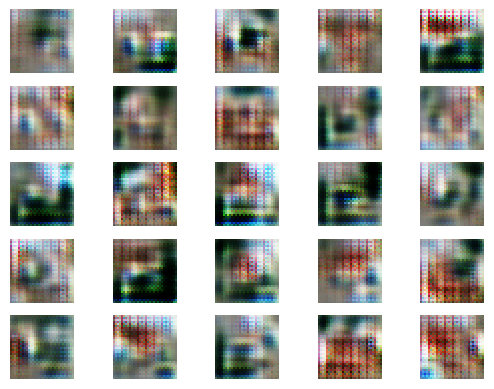

In [ ]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('/content/cifar_generator_2epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)
